<a href="https://colab.research.google.com/github/followviny/ML_kaggle/blob/main/ml_phonemes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**[<font size=6>👂Phonemes</font>](https://www.kaggle.com/t/a5edd3644af742aa9e7bede03565a3ad)**.

In [ ]:
df = pd.read_csv('XY_Phonemes.csv', low_memory=False); df

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x249,x250,x251,x252,x253,x254,x255,x256,SpkrID,g
0,11.14,15.17,19.12,18.78,13.79,18.98,20.09,19.16,17.32,19.76,...,7.79,10.95,10.05,8.67,10.84,9.50,7.96,9.04,0,NaN
1,10.84,15.20,19.80,17.82,14.10,17.93,19.54,20.97,16.65,22.41,...,12.95,13.05,11.95,11.07,10.81,9.71,11.57,12.22,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59998,12.15,15.78,21.27,19.61,15.14,21.44,23.24,20.91,17.42,21.22,...,8.82,8.00,7.44,8.32,6.51,8.33,6.83,7.02,436,ao
59999,14.78,14.08,15.70,15.51,15.36,15.52,14.68,15.57,15.48,15.45,...,12.87,13.26,13.16,12.65,13.90,13.10,11.16,13.53,436,sh


In [ ]:
df.info()   # observe datatypes and any missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 258 entries, x1 to g
dtypes: float64(256), int64(1), object(1)
memory usage: 118.1+ MB


In [ ]:
# Change string labels to numbers in order of increasing size of the entity (Star < Quasi Star < Galaxy)
# df.Class = df.Class.apply(lambda C: -1 if C=='S' else 0 if C=='Q' else 1 if C=='G' else None)

In [ ]:
vX = df.query('g!=g').drop('g', axis=1)  # slice a test sample (10K observations)
tXY = df.query('g==g')                   # slice training sample
tX, tY = tXY.drop('g', axis=1), tXY.g    # split into training I/O (60K-10K = 50K observation)

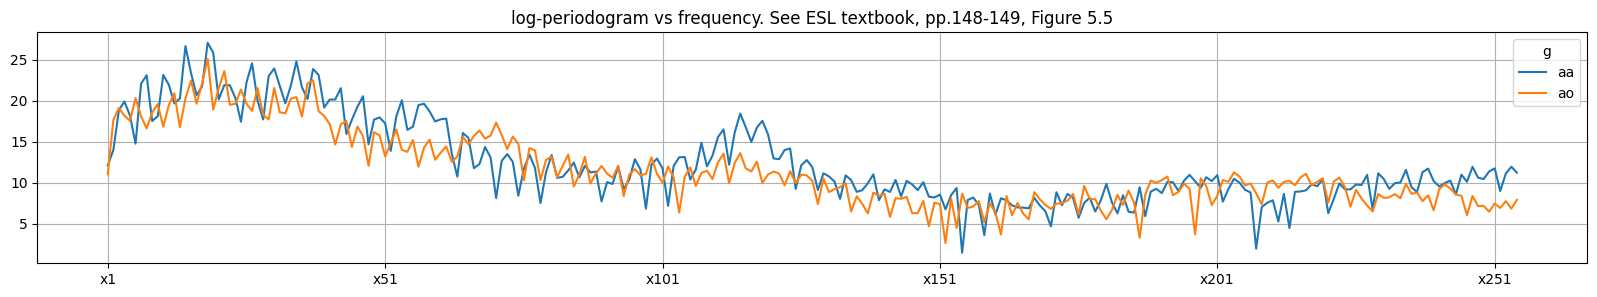

In [ ]:
aa = tXY[tXY.g=='aa'].set_index('g').iloc[[0],0:255]
ao = tXY[tXY.g=='ao'].set_index('g').iloc[[0],0:255]
_ = pd.concat([aa,ao]).T.plot(figsize=(20,3), grid=True, title='log-periodogram vs frequency. ESL textbook, pp.148-149, Figure 5.5');

<Figure size 1000x800 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Correlation Heatmap of Features')

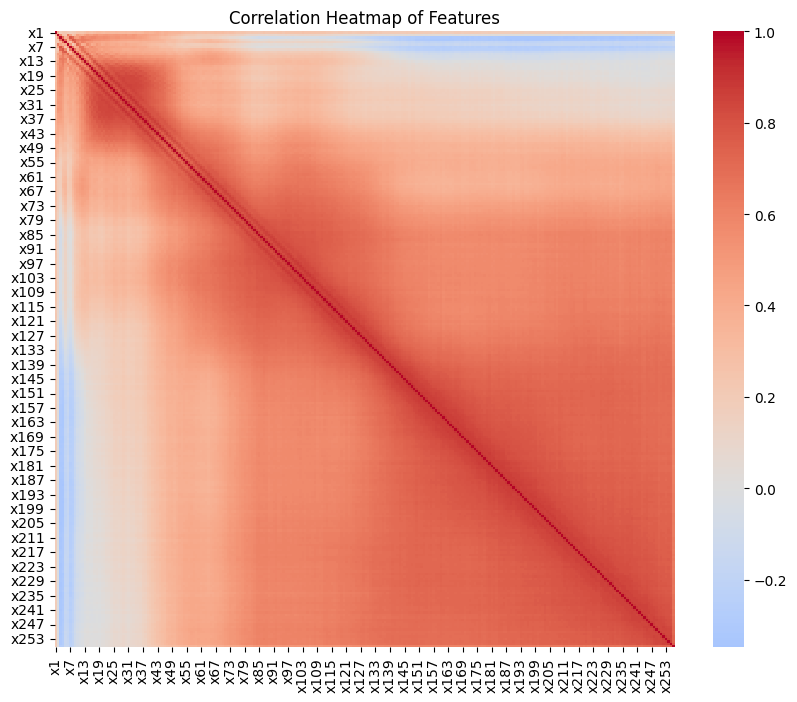

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = tX.iloc[:, :256].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features')
plt.show()
# many correlations -> reduce dim

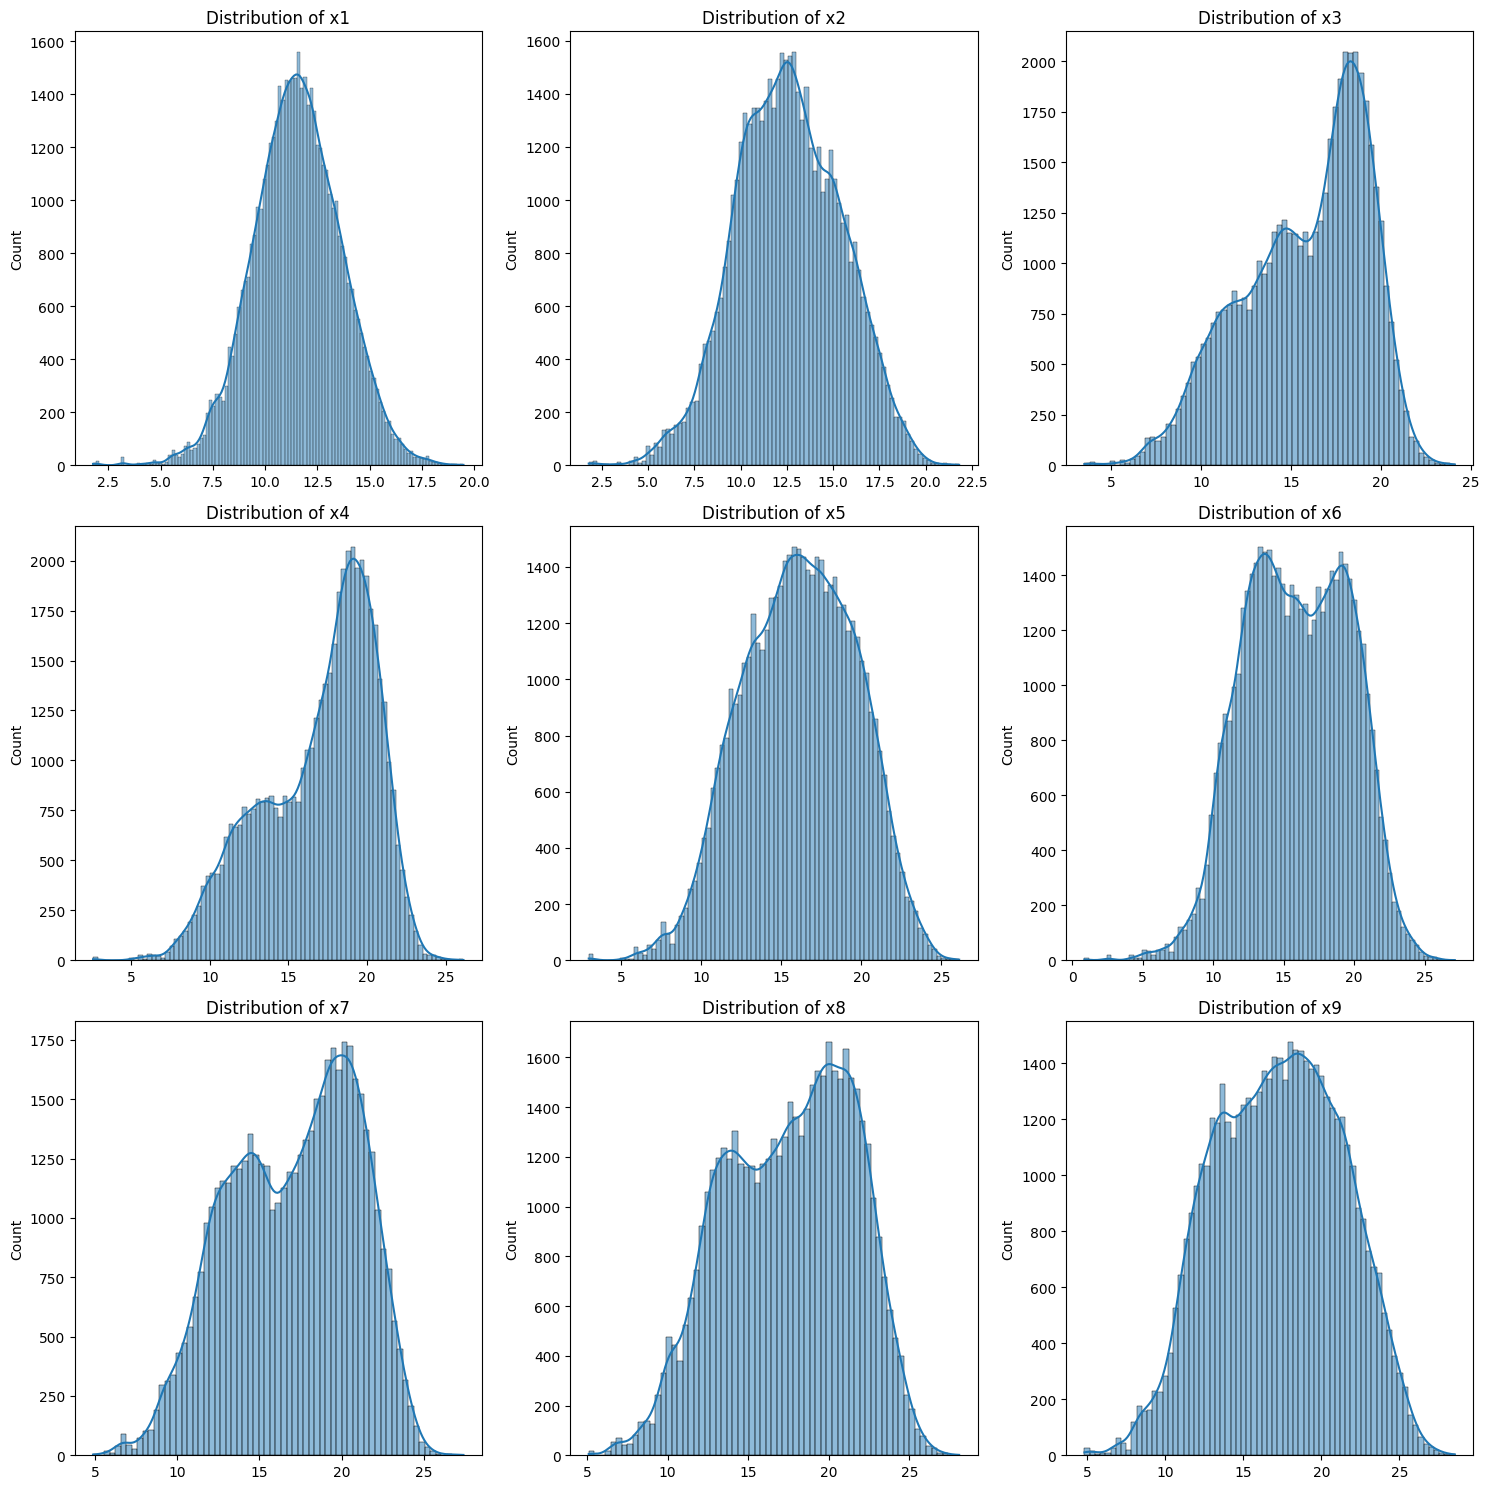

Top 10 most skewed features:
x231    0.53
x201    0.50
        ... 
x244    0.47
x200    0.47
Length: 10, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_distribution(data, columns, rows=3, cols=3):
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    axes = axes.flatten()
    for i, col in enumerate(columns):
        if i >= len(axes):
            break
        sns.histplot(data[col], kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel('')

    plt.tight_layout()
    plt.show()
plot_distribution(tX, tX.columns[0:9])
skewness = tX.skew().sort_values(ascending=False)
print("Top 10 most skewed features:")
print(skewness.head(10))
# no transformation like log needed bc they're not skewed much

<font color=green><h3><b>$\alpha$ Reducing dimensions.

<Figure size 1000x700 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'PCA 2D Scatter Plot')

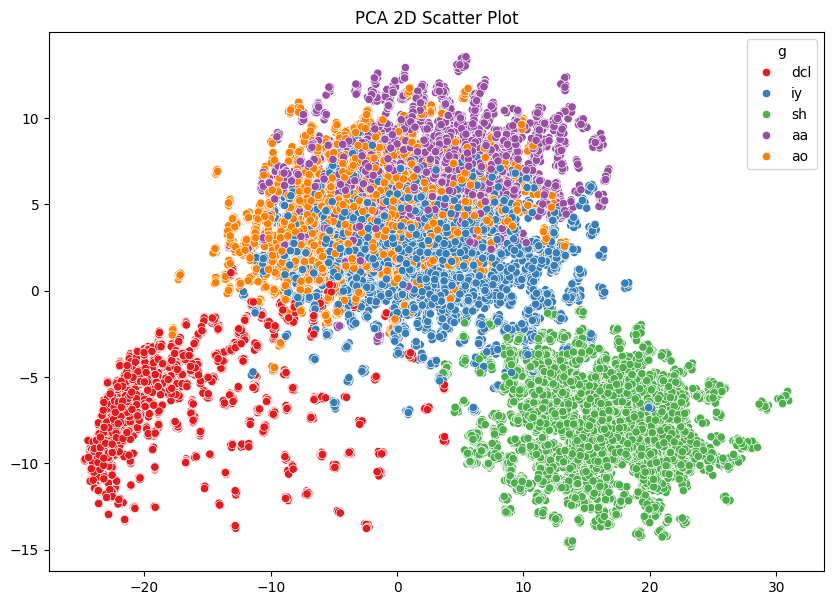

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import DBSCAN
#from sklearn.feature_selection import SelectKBest, f_classif

# Split the data
X_train, X_val, y_train, y_val = train_test_split(tX, tY, test_size=0.2, random_state=42, stratify=tY)

#tried minmax scaler -> got a bit worse score
# Standardize
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
vX_scaled = scaler.transform(vX)

# Reduce dimensions
pca = PCA(n_components=0.95)  # tried 0.99 got worse
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
vX_pca = pca.transform(vX_scaled)

#tried selectKBest -> score got worse

#selector = SelectKBest(f_classif, k=100)  # Select top 100 features -> lda got worse
#X_train_pca = selector.fit_transform(X_train_scaled, y_train)
#X_val_pca = selector.transform(X_val_scaled)
#vX_pca = selector.transform(vX_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_train_pca[:, 0], y=X_train_pca[:, 1], hue=y_train, palette='Set1')
plt.title("PCA 2D Scatter Plot")
plt.show()



<font color=green><h3><b>$\beta$. Fit the model to the training dataset</b><h3>

In [ ]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
#from sklearn.cluster import DBSCAN

#tried KNN,  Naive Bayes, QDA -> got worse results, LDA produces best
#KNN seems to overfit, showing high score in notebook, but low in kaggle

#tried DBSCAN to remove potential outliers, score got only worse
#dbscan = DBSCAN(eps=1.5, min_samples=5)
#outlier_labels = dbscan.fit_predict(X_train_pca)
#inlier_indices = np.where(outlier_labels != -1)[0]
#outlier_indices = np.where(outlier_labels == -1)[0]

def create_enhanced_features(X_pca, centers):
    distances = cdist(X_pca[:, :3], centers)  # distances to centers
    min_distances = distances.min(axis=1).reshape(-1, 1)  # Min dist
    sorted_distances = np.sort(distances, axis=1)
    distance_ratios = (sorted_distances[:, 0] / sorted_distances[:, 1]).reshape(-1, 1)
    return np.column_stack([X_pca, distances, min_distances, distance_ratios])

# Since clustering algorithms are allowed, tried KMeans with 5 clusters, bc 5 phoneme types
# tried init='k-means++' -> got better result
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, random_state=42)
cluster_centers = kmeans.fit(X_train_pca[:, :3]).cluster_centers_

#features
X_train_clustered = create_enhanced_features(X_train_pca, cluster_centers)
X_val_clustered = create_enhanced_features(X_val_pca, cluster_centers)
vX_clustered = create_enhanced_features(vX_pca, cluster_centers)

best_model = LDA(shrinkage=0.1, solver='lsqr')  #found best parameters using gridsearch
best_model.fit(X_train_clustered, y_train)

cv_scores_with = cross_val_score(best_model, X_train_clustered, y_train, cv=5)
print("CV Scores with outliers:", cv_scores_with.mean())

val_predictions = best_model.predict(X_val_clustered)
print(f"Validation Set Accuracy: {best_model.score(X_val_clustered, y_val):.4f}")



LinearDiscriminantAnalysis(shrinkage=0.1, solver='lsqr')

CV Scores with outliers: 0.926225
Validation Set Accuracy: 0.9242


<Figure size 1000x700 with 0 Axes>

<Axes: >

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 47.7222222222222, 'Predicted Labels')

Text(95.72222222222221, 0.5, 'True Labels')

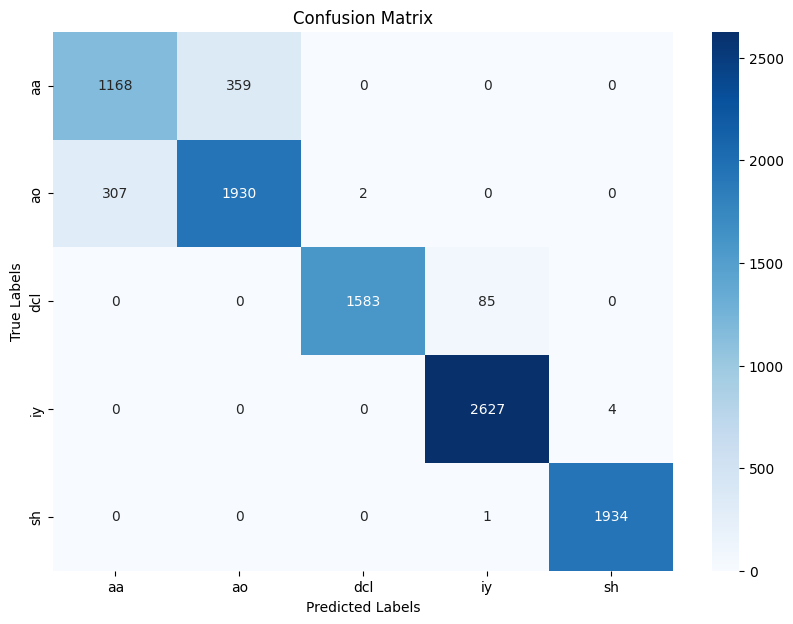

              precision    recall  f1-score   support

          aa       0.79      0.76      0.78      1527
          ao       0.84      0.86      0.85      2239
         dcl       1.00      0.95      0.97      1668
          iy       0.97      1.00      0.98      2631
          sh       1.00      1.00      1.00      1935

    accuracy                           0.92     10000
   macro avg       0.92      0.91      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_val, val_predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
print(classification_report(y_val, val_predictions))

<font color=green><h3><b>$\gamma$. Generate predictions</b><h3>

In [ ]:
pY = pd.DataFrame(best_model.predict(vX_clustered), index=range(1, len(vX_clustered) + 1), columns=['g'])
#ToCSV(pY, '👂Model_KMeans_Enhanced')

<font color=green><h3><b>$\epsilon$.
Documentation</b></h3></font>

<font color=green><h4><b>Task 1. Decisions in Preprocessing Pipeline</b></h4></font>

<font color=green>
Elements of preprocessing pipeline.</font>


1. Explanation of Decisions in Preprocessing Pipeline:

*   Feature Standartization: StandardScalar was used to standartize the features. This decision was made, because many machine learning algorithms work better with data that has unit variance and is centered around zero as I learned from ISLP book.
*   Dimensionality Reduction: I used PCA to reduce the dimensionality of the dataset. By lowering noise and irrelevant features, PCA strengthened the model. I made some experiments to determine that 0.95 was the ideal number because greater levels led to lower performance.
*   Clustering: applied KMeans clustering with 5 clusters, bc there are 5 phoneme types and used the cluster centers to create enhanced features, including the distance to the nearest cluster center and the ratio of distances to the closest and second-closest centers.
* Model discussion in next section

2. Effectiveness Evaluation:

*   Cross-Validation Scores: Cross-validation scores were used to assess how effective the preparation stages were (cross_val_score). This gives information on the model's ability to generalize to new data.
*   Validation Set Accuracy: After feature engineering and preprocessing, the accuracy on the validation set acts as a last check on model performance.
* KMeans-enhanced features showed noticeable improvement in both cross-validation and final validation scores.
PCA led to faster training times and a more stable model by eliminating noise, without sacrificing accuracy.

3. Other Attempts:

*   Attempts of Feature Selection: Performance was not enhanced by using SelectKBest to choose the best features, indicating that PCA was a better method for reducing dimensionality in this situation.
*   DBSCAN for Outlier Removal: Outlier identification attempts using DBSCAN produced worse results, suggesting that either the removal of outliers was harmful or that they may not have had a substantial influence on model performance. It also takes too much time.
*  Winsorization: I experimented with Winsorization to cap outliers, but removing outliers using this method also didn't help and made score worse
* Tried to separate data using speaker ID, but it also didn't produce valuable results













<font color=green><h4><b>Task 2. Decisions in Modeling Pipeline</b></h4></font>

<font color=green>
Modeling approach.


1. How did these decisions guide in modeling?

I decided to go with LDA because it performed the best out of all the models I tested. LDA is a choice, for classification tasks that involve interconnections, between variables and the requirement for a method that doesn't tend to overfit easily.
LDA also has a shrinkage parameter (`shrinkage set to 0.1`). This parameter was determined through GridSearch in order to enhance the models reliability and prevent overfitting.
I also applied the KMeans algorithm to form 5 clusters as there are 5 types of phonemes in our study setup. This was beneficial, as incorporating distances, to cluster centers helped in the models ability to differentiate between groups effectively.
I used PCA for dimensionality reduction to maintain 95% of the variability intact which helped in cutting down the number of features and minimizing noise, for outcomes overall. I experimented with varying parameter settings. Found that they resulted in performance. Our choices were driven by the aim to boost the models ability to generalize and decrease training time by employing feature reduction (PCA) and eliminating noise (such, as getting rid of outliers and generating features through clustering).

2. How do you evaluate the effectiveness of these elements?

Cross-validation metrics were used to assess the quality of the model. After feature engineering and preprocessing, the accuracy on the validation set acts as a last check on model performance.
LDA was chosen for its baseline effectiveness, and the shrinkage parameter was tuned based on cross-validation results.

3. What else have you tried that worked or didn't?

Compared to LDA, QDA, Naive Bayes KNN performed worse. Maybe the class variances may have been too close to one another for QDA to handle the data well. KNN performed poorly on the test set but well on the training set, indicating overfitting. This implies that KNN's ability to generalize to the dependencies in the data was lacking.
Perhaps as a result of the model's strong assumption of feature independence, which was at odds with the data's structure, Naive Bayes performed worse than LDA.
Also logistic regression did not perform as well as LDA because it was unable to handle correlated features as well.

<font color=green><h3><b>$\zeta$. References</b></h3></font>


1. Géron, A. (2019). Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems (2nd ed.). O'Reilly Media.

2. https://learn.codesignal.com/preview/lessons/1969/deciphering-dimensionality-reduction-pca-vs-lda-techniques-and-implementation

3. James, G., Witten, D., Hastie, T., & Tibshirani, R. (2023). An Introduction to Statistical Learning with Applications in Python.

4. Documentation for Scikit-learn. Scikit-learn: Machine Learning in Python. Retrieved from https://scikit-learn.org/stable/documentation.html

5. StackOverflow. https://stackoverflow.com

6. https://www.aiacceleratorinstitute.com/mastering-data-clustering-your-comprehensive-guide-to-k-means-and-k-means/